In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split
from keras.utils.vis_utils import plot_model
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# da moze da koristi funkcije definisane u svesci SharedFunctions

%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

U ovom slučaju, koristi se samo deo podataka koji ima neku labelu, tj. samo toksični komentari. Njih je potrebno klasifikovati u 6 različitih klasa (sa preklapanjem).

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [5]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,word_count
6,cocksucker before you piss around on my work,1,1,1,0,1,0,1,8
12,hey what is it talk what is it an exclusive...,1,0,0,0,0,0,1,50
16,bye dont look come or think of comming back ...,1,0,0,0,0,0,1,10
42,you are gay or antisemmitian archangel white...,1,0,1,0,1,1,1,109
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,1,8


In [6]:
data.shape

(22468, 9)

**Dakle, broj instanci za višelabelarnu klasifikaciju je 22468.**

In [7]:
# prosecan broj reci po komentaru

data['word_count'].mean()

48.906044151682394

In [8]:
# Broj komentara po klasama: 

get_label_counts(data, labels)

{'toxic': 21384,
 'severe_toxic': 1962,
 'obscene': 12140,
 'threat': 689,
 'insult': 11304,
 'identity_hate': 2117}

Klasa toxic značajno preovladava skupom. Klase severe_toxic, identity_hate i threat (ova klasa posebno mali broj instanci) su u manjini.

### 1. Podela na trening, test, i validacioni skup

Koristi se iterative_train_test_split iz paketa skmultilearn.model_selection za stratifikovanu podelu:

In [9]:
X = data['comment_text']
y = data[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
                                                        np.asmatrix(X).T, np.asmatrix(y), test_size = 0.35)

#X_train, y_train, X_validation, y_validation = iterative_train_test_split(
#                                            X_train_validation, y_train_validation, test_size = 0.2)

In [10]:
X_test.shape, X_train.shape

((7818, 1), (14650, 1))

In [11]:
X_train = pd.DataFrame(X_train, columns=['comment_text'])['comment_text']
X_test = pd.DataFrame(X_test, columns=['comment_text'])['comment_text']
#X_train_validation = pd.DataFrame(X_train_validation, columns=['comment_text'])['comment_text']
#X_validation = pd.DataFrame(X_validation, columns=['comment_text'])['comment_text']

y_train = pd.DataFrame(y_train, columns=labels)[labels]
y_test = pd.DataFrame(y_test, columns=labels)[labels]
#y_train_validation = pd.DataFrame(y_train_validation, columns=labels)[labels]
#y_validation = pd.DataFrame(y_validation, columns=labels)[labels]

### 2. Priprema teksta

Koraci su isti kao u prethodnoj svesci (u slučaju binarne klasifikacije).

In [12]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [13]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_multi.pickle')

In [14]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 35233


In [15]:
X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
#X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)
#X_train_validation_transformed = to_sequence(X_train_validation, max_len, tokenizer)

In [16]:
X_train_transformed.shape, X_test_transformed.shape

((14650, 100), (7818, 100))

In [17]:
# kreiranje matrice ugnjezdjavanja

embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)

### 3. Formiranje modela

In [18]:
# parametri izabrani isprobavanjem

kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.2
embedding_dim = 100
lr = 0.01
layers = 0

In [19]:
multi_model = create_model(num_of_classes = 6, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

### 4. Obučavanje modela

In [20]:
# i ovde se koriste tezine pri klasifikaciji, zbog nebalansiranih klasa

weights = get_weights(data[labels].to_numpy(), 6)
weights

{0: 0.17511535104127696,
 1: 1.90859667006456,
 2: 0.3084568918176826,
 3: 5.43492985002419,
 4: 0.3312691672564284,
 5: 1.7688552983782082}

In [21]:
epochs = 20
batch_size = 128

In [22]:
start = time.time()    

multi_history = multi_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                validation_split=0.2,
                                class_weight=weights, verbose=False)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Trajanje obucavanja modela multilabel klasifikacije:  37.23643779754639


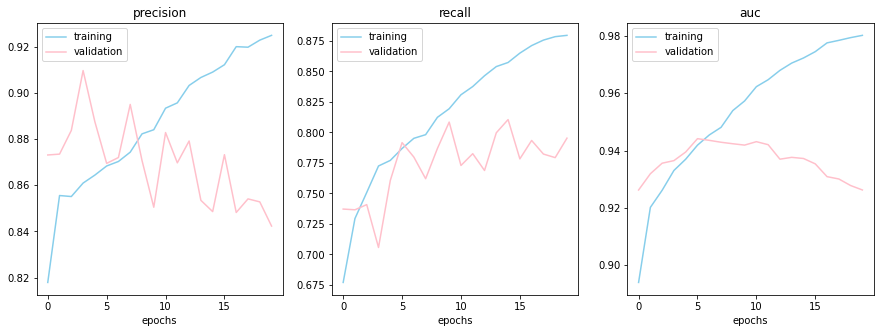

In [23]:
plot_graphs(multi_history, ['precision', 'recall', 'auc'])

### 5. Evaluacija modela

In [24]:
scores = multi_model.evaluate(X_train_transformed, y_train)
print('Train Loss: ', scores[0])
print('Train Precision: ', scores[1])
print('Train Recall: ', scores[2])
print('Train AUC:', scores[3])
print('Train F1: ', scores[4])

458/458 [==============================] - 2s 4ms/step - loss: 0.1924 - precision: 0.9174 - recall: 0.8851 - auc: 0.9754 - f1_m: 0.9014
Train Loss:  0.19242028892040253
Train Precision:  0.917427659034729
Train Recall:  0.8850699663162231
Train AUC: 0.9753600358963013
Train F1:  0.9013656377792358


In [25]:
scores = multi_model.evaluate(X_test_transformed, y_test)
print('Test Loss: ', scores[0])
print('Test Precision: ', scores[1])
print('Test Recall: ', scores[2])
print('Test AUC:', scores[3])
print('Test F1: ', scores[4])

245/245 [==============================] - 1s 4ms/step - loss: 0.4317 - precision: 0.8252 - recall: 0.7848 - auc: 0.9166 - f1_m: 0.8031
Test Loss:  0.4316956698894501
Test Precision:  0.8252362608909607
Test Recall:  0.7847802042961121
Test AUC: 0.9166058897972107
Test F1:  0.8030501008033752


Predviđanje:

In [26]:
y_predicted = multi_model.predict(X_test_transformed)

In [27]:
# Prag se postavlja na 0.4 za zastupljenije klase, i 0.2 za manje zastupljene
# jer nam je cilj da maksimuzujemo odziv
# Bolje da imamo vise lazno pozitivnih nego lazno negativnih

def translate(array):
    
    res1 = [1 if x>0.5 else 0 for x in array[::2]]
    res2 = [1 if x>0.2 else 0 for x in array[1::2]]

    res = []
    for r1, r2 in zip(res1, res2):
        res.append(r1)
        res.append(r2)

    return res

result = map(translate, y_predicted)

y_labels = list(result)
cf = multilabel_confusion_matrix(y_test, y_labels)

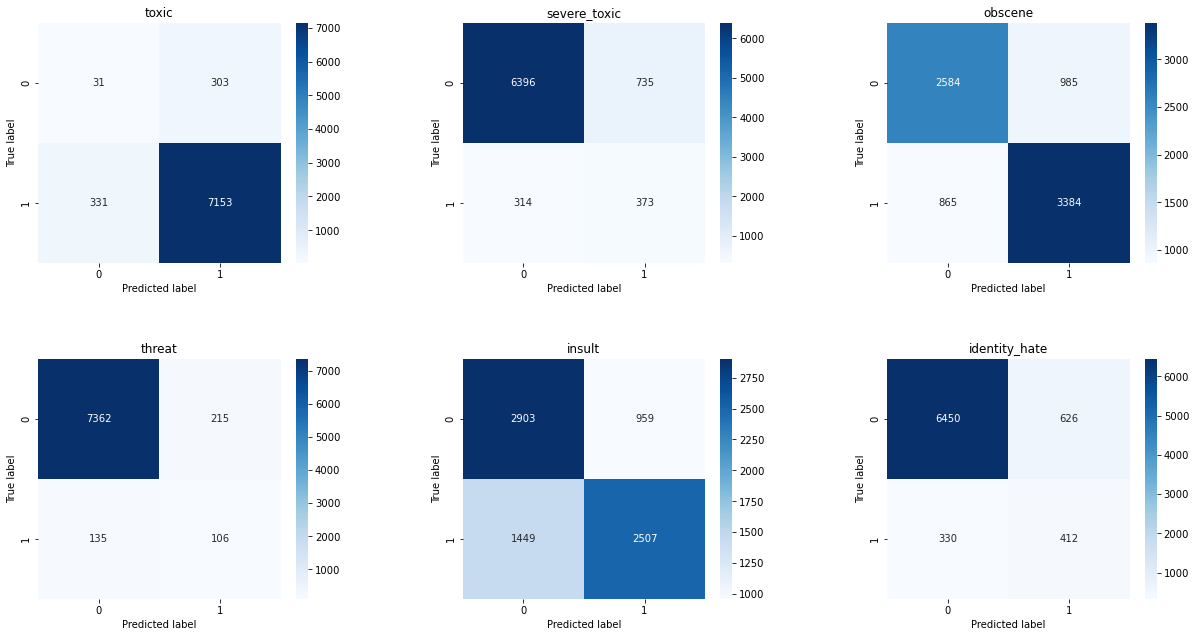

In [28]:
plot_cf(cf, 'multi', labels)

**Model ne predviđa dobro za klase severe_toxic, threat, i identity hate, što i jesu klase sa najmanjim brojem podataka**

In [29]:
print('Brojnost po klasama na test skupu:')
print(get_label_counts(y_test, labels))

Brojnost po klasama na test skupu:
{'toxic': 7484, 'severe_toxic': 687, 'obscene': 4249, 'threat': 241, 'insult': 3956, 'identity_hate': 742}


In [30]:
# print(metrics.classification_report(y_test, y_labels,target_names=labels))

Preciznost, odziv i F1 mera za svaku klasu:

In [31]:
precisions, recalls, f1_scores = get_prec_rec_f1(cf, labels)

In [32]:
precisions

{'toxic': 0.96,
 'severe_toxic': 0.34,
 'obscene': 0.77,
 'threat': 0.33,
 'insult': 0.72,
 'identity_hate': 0.4}

In [33]:
recalls

{'toxic': 0.96,
 'severe_toxic': 0.54,
 'obscene': 0.8,
 'threat': 0.44,
 'insult': 0.63,
 'identity_hate': 0.56}

In [34]:
f1_scores

{'toxic': 0.96,
 'severe_toxic': 0.42,
 'obscene': 0.78,
 'threat': 0.38,
 'insult': 0.67,
 'identity_hate': 0.47}

In [64]:
new_comments = ['i will kill you', 'go die', 'you are so stupid', 'You suck!']
new = to_sequence(new_comments, 100, tokenizer)

probs = multi_model.predict(new)

predictions = []

for prob in probs:
    rounded = [round(p) for p in prob]
    predictions.append(rounded)
        
model_preds = pd.DataFrame(predictions, columns=labels)
model_preds['comment'] = new_comments

In [65]:
print('Predvidjanja za nove komentare: ')
model_preds

Predvidjanja za nove komentare: 


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment
0,1,0,0,1,0,0,i will kill you
1,1,0,0,1,0,0,go die
2,1,0,1,0,1,0,you are so stupid
3,1,0,1,0,1,0,You suck!


### Čuvanje modela

In [37]:
multi_model.save_weights('models/multi_model_weights.hdf5')
multi_model.save('models/multi_model.hdf5')

In [38]:
# model = keras.models.load_model('models/multi_model.hdf5', custom_objects={"f1_m": f1_m})
# plot_model(model, to_file='plots and images/multi_model.png', show_shapes=True) 
# model.get_config()